Step 1: Preprocess the Data

In [8]:
import pandas as pd

# Assuming the file path to the dataset you uploaded
file_path = '/Users/chamodyaavishka/Desktop/NEW/NEW1/Datanew.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows to understand its structure
print(data.head())


                                           Utterance  \
0  Alexa open airport info and tell me the delay ...   
1                               Alexa, open deadpool   
2  Alexa, how do I plant a garden? - "To plant a ...   
3             Alexa, play original songs from jw.org   
4                Alexa, Ask Verizon about my rewards   

                                            Response       Source  \
0  Sorry, I couldn't find your current location i...  Alexa Skill   
1                               Here’s what I found.  Alexa Skill   
2  "To plant a garden, choose a location, prepare...     Built-in   
3                                                NaN  Alexa Skill   
4                              <Audio only response>  Alexa Skill   

              Department    Skill Name  Labels  
0                  Local  Airport Info       1  
1            Movies & TV      Deadpool       0  
2                    NaN           NaN       1  
3  Education & Reference       JW.ORG®       0  
4  

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the dataset
encoded_data = tokenizer(data['Utterance'].tolist(), 
                         padding=True, 
                         truncation=True, 
                         return_tensors='pt', 
                         max_length=128)  # You can adjust `max_length` based on your dataset


In [10]:
from sklearn.preprocessing import LabelEncoder
import torch

# Binary labels for violation detection
labels = torch.tensor(data['Labels'].values)

# Encode categorical features
source_encoder = LabelEncoder()
department_encoder = LabelEncoder()
skill_name_encoder = LabelEncoder()

data['Source'].fillna('Unknown', inplace=True)
data['Department'].fillna('Unknown', inplace=True)
data['Skill Name'].fillna('Unknown', inplace=True)

source = torch.tensor(source_encoder.fit_transform(data['Source']))
department = torch.tensor(department_encoder.fit_transform(data['Department']))
skill_name = torch.tensor(skill_name_encoder.fit_transform(data['Skill Name']))


/var/folders/58/g_5xrc8j1zdckrn739h9xr2m0000gn/T/ipykernel_18446/3596481432.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Source'].fillna('Unknown', inplace=True)
/var/folders/58/g_5xrc8j1zdckrn739h9xr2m0000gn/T/ipykernel_18446/3596481432.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    encoded_data['input_ids'], labels, random_state=42, test_size=0.1)

train_masks, validation_masks = train_test_split(
    encoded_data['attention_mask'], random_state=42, test_size=0.1)

train_source, validation_source, train_department, validation_department, train_skill_name, validation_skill_name = train_test_split(
    source, department, skill_name, test_size=0.1, random_state=42)


Define the Multitask Model Architecture

In [12]:
from transformers import BertModel
import torch.nn as nn

class MultitaskBERTModel(nn.Module):
    def __init__(self, num_labels, num_sources, num_departments, num_skills):
        super(MultitaskBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.source_classifier = nn.Linear(self.bert.config.hidden_size, num_sources)
        self.department_classifier = nn.Linear(self.bert.config.hidden_size, num_departments)
        self.skill_name_classifier = nn.Linear(self.bert.config.hidden_size, num_skills)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        violation_logits = self.classifier(pooled_output)
        source_logits = self.source_classifier(pooled_output)
        department_logits = self.department_classifier(pooled_output)
        skill_name_logits = self.skill_name_classifier(pooled_output)
        return violation_logits, source_logits, department_logits, skill_name_logits


 Initialize the Model and Optimizer

In [13]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultitaskBERTModel(
    num_labels=2,  # Binary classification for violation detection
    num_sources=len(source_encoder.classes_),
    num_departments=len(department_encoder.classes_),
    num_skills=len(skill_name_encoder.classes_)
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# Convert the dataset to TensorDataset and create DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels, train_source, train_department, train_skill_name)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)

validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_source, validation_department, validation_skill_name)
validation_dataloader = DataLoader(validation_dataset, sampler=SequentialSampler(validation_dataset), batch_size=32)

total_steps = len(train_dataloader) * epochs  # epochs is the number of training epochs you plan to run
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/Users/chamodyaavishka/anaconda3/envs/NEW/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Training and Validation Loop

In [14]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.mean(pred_flat == labels_flat)

epochs = 100  # Define the number of epochs
loss_values, validation_loss_values = [], []
accuracy_values, validation_accuracy_values = [], []  # Corrected line

for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0  # Initialize total accuracy for the training phase
    
    # Training phase
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_source, b_department, b_skill_name = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        loss = sum([nn.CrossEntropyLoss()(output, target) for output, target in zip(outputs, [b_labels, b_source, b_department, b_skill_name])])
        total_loss += loss.item()
        
        # Assuming the first output corresponds to the main task (e.g., violation detection)
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_accuracy += flat_accuracy(logits, label_ids)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    loss_values.append(avg_train_loss)
    accuracy_values.append(avg_train_accuracy)
    
    # Validation phase
    model.eval()
    eval_loss = 0
    eval_accuracy = 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_source, b_department, b_skill_name = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_loss += sum([nn.CrossEntropyLoss()(output, target).item() for output, target in zip(outputs, [b_labels, b_source, b_department, b_skill_name])])
        eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_loss = eval_loss / len(validation_dataloader)
    avg_val_accuracy = eval_accuracy / len(validation_dataloader)
    validation_loss_values.append(avg_val_loss)
    validation_accuracy_values.append(avg_val_accuracy)
    
    print(f"Epoch {epoch_i + 1}: Train loss: {avg_train_loss}, Train accuracy: {avg_train_accuracy}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}.")



Epoch 1: Train loss: 8.415287673473358, Train accuracy: 0.4674479166666667, Validation Loss: 7.691330790519714, Validation Accuracy: 0.6153846153846154.
Epoch 2: Train loss: 7.586068391799927, Train accuracy: 0.6067708333333334, Validation Loss: 6.832981884479523, Validation Accuracy: 0.6923076923076923.
Epoch 3: Train loss: 6.865836143493652, Train accuracy: 0.66015625, Validation Loss: 6.1678803861141205, Validation Accuracy: 0.6923076923076923.
Epoch 4: Train loss: 6.417481601238251, Train accuracy: 0.7135416666666666, Validation Loss: 5.661271616816521, Validation Accuracy: 0.7692307692307693.
Epoch 5: Train loss: 5.734412908554077, Train accuracy: 0.7213541666666666, Validation Loss: 5.308958165347576, Validation Accuracy: 0.7692307692307693.
Epoch 6: Train loss: 5.34120112657547, Train accuracy: 0.7526041666666666, Validation Loss: 4.9919348657131195, Validation Accuracy: 0.7307692307692307.
Epoch 7: Train loss: 5.032673627138138, Train accuracy: 0.75390625, Validation Loss: 4.77

Train the Model

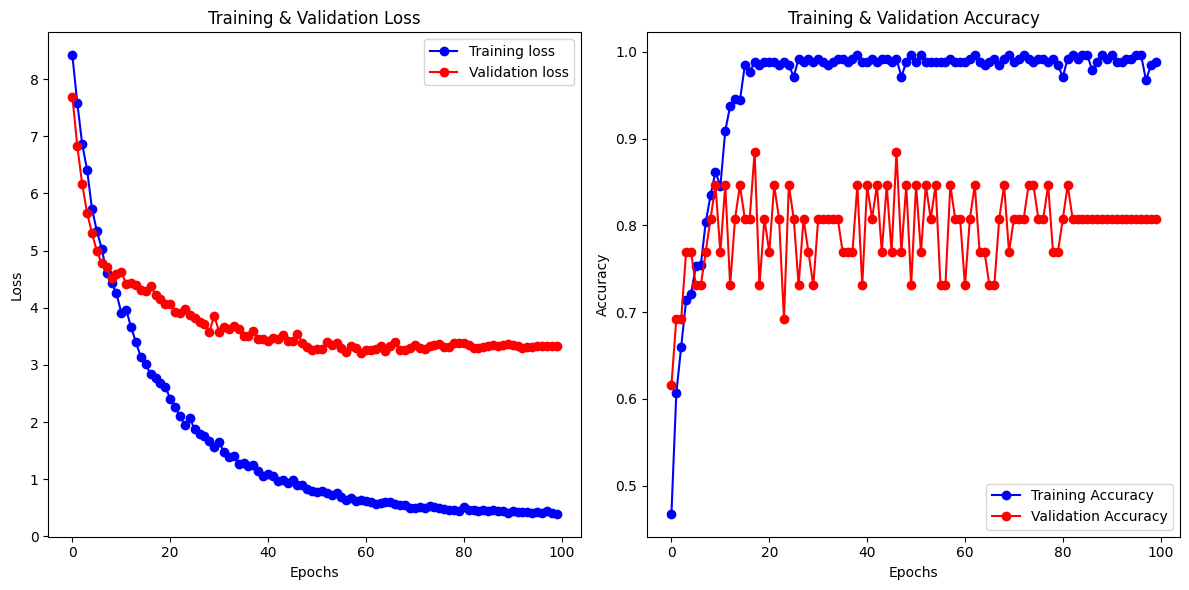

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(loss_values, 'b-o', label="Training loss")
plt.plot(validation_loss_values, 'r-o', label="Validation loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, 'b-o', label="Training Accuracy")
plt.plot(validation_accuracy_values, 'r-o', label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Inference with the Trained Model

In [16]:
def predict(model, tokenizer, utterance, source_encoder, department_encoder, skill_name_encoder):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Tokenize and encode the utterance
    inputs = tokenizer(utterance, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    # Decode the predictions
    violation_pred = torch.argmax(outputs[0], dim=1).cpu().numpy()[0]
    source_pred = source_encoder.inverse_transform([torch.argmax(outputs[1], dim=1).cpu().numpy()[0]])[0]
    department_pred = department_encoder.inverse_transform([torch.argmax(outputs[2], dim=1).cpu().numpy()[0]])[0]
    skill_name_pred = skill_name_encoder.inverse_transform([torch.argmax(outputs[3], dim=1).cpu().numpy()[0]])[0]
    
    return {
        "violation": bool(violation_pred),
        "source": source_pred,
        "department": department_pred,
        "skill_name": skill_name_pred
    }

# Example usage
utterance = "Alexa, what's my Flash Briefing?"
predictions = predict(model, tokenizer, utterance, source_encoder, department_encoder, skill_name_encoder)
print(predictions)


{'violation': False, 'source': 'Alexa Skill', 'department': 'Connected Car', 'skill_name': 'Labs Flash Briefing'}


Save the Model and Tokenizer

In [34]:
import os
import torch

# Define the path where you want to save the model and tokenizer
save_path = "/Users/chamodyaavishka/Desktop/NEW/modelapril"

# Ensure the save path exists
os.makedirs(save_path, exist_ok=True)

# Save the model state dictionary
model_save_path = os.path.join(save_path, "pytorch_model.bin")
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
tokenizer_save_path = save_path  # Tokenizer can be saved using save_pretrained directly
tokenizer.save_pretrained(tokenizer_save_path)


('/Users/chamodyaavishka/Desktop/NEW/modelapril/tokenizer_config.json',
 '/Users/chamodyaavishka/Desktop/NEW/modelapril/special_tokens_map.json',
 '/Users/chamodyaavishka/Desktop/NEW/modelapril/vocab.txt',
 '/Users/chamodyaavishka/Desktop/NEW/modelapril/added_tokens.json')

In [35]:
import joblib

# Save the encoders
joblib.dump(source_encoder, os.path.join(save_path, "source_encoder.joblib"))
joblib.dump(department_encoder, os.path.join(save_path, "department_encoder.joblib"))
joblib.dump(skill_name_encoder, os.path.join(save_path, "skill_name_encoder.joblib"))


['/Users/chamodyaavishka/Desktop/NEW/modelapril/skill_name_encoder.joblib']

In [44]:
model_save_path = '/Users/chamodyaavishka/Desktop/NEW/ap2'
torch.save(model.state_dict(), model_save_path)


RuntimeError: File /Users/chamodyaavishka/Desktop/NEW/ap2 cannot be opened.

In [39]:
from transformers import BertTokenizer
from multi_task_bert_model import MultitaskBERTModel
  # Ensure to import your model class
import torch
import joblib

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(tokenizer_save_path)

# Initialize the model and load the state dictionary
model = MultitaskBERTModel(...)  # You need to specify the correct arguments for your model initialization
model_state_dict = torch.load(model_save_path)
model.load_state_dict(model_state_dict)
model.eval()  # Set the model to evaluation mode

# Load the label encoders
source_encoder = joblib.load(os.path.join(save_path, "source_encoder.joblib"))
department_encoder = joblib.load(os.path.join(save_path, "department_encoder.joblib"))
skill_name_encoder = joblib.load(os.path.join(save_path, "skill_name_encoder.joblib"))


TypeError: MultitaskBERTModel.__init__() missing 1 required positional argument: 'num_skills'

Load the Model, Tokenizer, and Label Encoders for Future Use

In [ ]:
from transformers import BertModel, BertTokenizer
import joblib

# Load the model
model = BertModel.from_pretrained("/Users/chamodyaavishka/Desktop/NEW/modelapril")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("/Users/chamodyaavishka/Desktop/NEW/modelapril")

# Load the label encoders
source_encoder = joblib.load(f"{label_encoders_path}/source_encoder.joblib")
department_encoder = joblib.load(f"{label_encoders_path}/department_encoder.joblib")
skill_name_encoder = joblib.load(f"{label_encoders_path}/skill_name_encoder.joblib")
